In [1]:
from pysam import VariantFile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys

In [2]:
class VariantResults:
    def __init__(self,patient,model_name="v2-500m-multi-species",window_length="1500"):
        """
        Parameters:
            self.window_length: The amount of bases to the left and right of each variant that is analyzed. This is also the size of the input sequences for the Nucleotide Transformer.
            self.model_name: The name of the Nucleotide Transformer model used.
            self.patient: The name of the patient (must match the folder containing the .vcf file and the outputs folder).
            self.vcf: A .vcf file containing all variants in the patient's genome that have passed the filtering step.
            self.bed: A .bed file containing the regions with variants.
        """
        self.window_length = 2*int(window_length) - 2*int(window_length)%6 # should be a multiple of 6
        self.model_name = model_name
        self.patient = patient
        self.myvcf = VariantFile(f"{patient}/NT_inputs/{patient}_analysis-ready-variants-combined-sorted.vcf.gz")
        self.bed = pd.read_csv(f'{patient}/NT_inputs/{patient}_intervals.bed', sep="\t", header=None)
        self.bed.columns = ["chr","start","end"]
    def generate_df(self):
        """
        The .bed files containing the scores of each chromosome are glued together to one dataframe.
        """
        p = Path(f"{self.patient}/outputs/scores_per_chrom").glob("*")
        filelist = [str(path) for path in p]
        self.results_df = pd.DataFrame({"Chromosome":[],"Index_in_bed":[],"Begin_6mer":[],"Cosine_Similarity":[],"Dot_Product":[],"1-L1_Loss":[],"1-MSE_Loss":[]})
        for i in tqdm(range(len(filelist))):
            try:
                chr_df = pd.read_csv(filelist[i],sep="\t",header=None)
                chr_df.rename(columns={0:"Chromosome",1:"Index_in_bed",2:"Begin_6mer",3:"Cosine_Similarity",4:"Dot_Product",5:"1-L1_Loss",6:"1-MSE_Loss"},inplace=True)
                self.results_df = pd.concat((self.results_df,chr_df),ignore_index = True).astype({'Index_in_bed': 'int32',"Begin_6mer":"int32"})
            except:
                continue
        print("sorting...")
        self.results_df.sort_values(by=["Chromosome","Begin_6mer"],inplace=True)
    def lowest_scores(self,lowest_metric,n=100,plot=True,results_df = None):
        """
        From the dataframe generated in generate_df, the n entries with the lowest score of one of the metrics are taken, plotted (if wanted), and exported to a .bed file.
        The results_df parameter can be specified as a dataframe other than self.results_df.
        This can be used to store the results_df outside of the class so that it doesn't have to be generated again if the class is changed.
        """
        if results_df is None:
            results_df = self.results_df
        self.lowest_scores_df = results_df.sort_values(by=lowest_metric).reset_index(drop=True).head(n)
        self.lowest_scores_df["Begin_Region"] = self.bed.iloc[self.lowest_scores_df["Index_in_bed"]]["start"].values
        self.lowest_scores_df["End_Region"] = self.bed.iloc[self.lowest_scores_df["Index_in_bed"]]["end"].values
        self.lowest_scores_df = self.lowest_scores_df[['Chromosome', 'Index_in_bed', 'Begin_Region', 'End_Region', 'Begin_6mer', 'Cosine_Similarity', 'Dot_Product', '1-L1_Loss', '1-MSE_Loss']]
        generated_index = []
        if plot:
            for index, row in tqdm(self.lowest_scores_df.iterrows(),total=n):
                if index in generated_index:
                    continue
                else:
                    generated_index.append(index)
                    self.metric_match_line_plot(index,row["Index_in_bed"],lowest_metric,results_df=results_df)
        self.lowest_scores_df.to_csv(f"{self.patient}/outputs/{self.patient}_{lowest_metric}_lowest_scores.bed", header=None,index=None, sep='\t', mode='w+')
        return self.lowest_scores_df
    def get_index_from_variant(self,chromosome,position):
        for index, row in self.bed[self.bed["chr"]==chromosome].iterrows():
            if row["start"]<=position and row["end"]>=position:
                return index
        print("No index found.")
        raise ValueError
    def stream_variants(self,chrom=None,start=None,end=None,index=None):
        """
        All variants in a certain region are printed.
        If the chromosome, the start position, and the end position are given as arguments, this region is searched.
        If an index is given, then the region at that index in the .bed file is searched.
        """
        if index is None:
            print(f"The segment at {chrom} from {start} to {end} contains the following variants:")
            print("CHROM","POS","REF","ALT")
            for vcf_rec in self.myvcf.fetch(chrom,start,end):
                print(vcf_rec.chrom,vcf_rec.pos,vcf_rec.ref,vcf_rec.alts[0])            
        else:
            row = self.bed.iloc[index]
            print(f"The segment at {row["chr"]} from {row["start"]} to {row["end"]} contains the following variants:")
            print("CHROM","POS","REF","ALT","QUAL")
            for vcf_rec in self.myvcf.fetch(row["chr"],row["start"], row["end"]):
                print(vcf_rec.chrom,vcf_rec.pos,vcf_rec.ref,vcf_rec.alts[0])
    def histogram_plot(self, n_bins = 1000, global_results_df=None):
        """
        A histogram depicting the frequency of cosine similarities and dot products is generated.
        """
        if global_results_df is None:
            results_df = self.results_df
        n_bins = 1000
        dist1 = global_results_df["Cosine_Similarity"]
        dist2 = global_results_df["Dot_Product"]

        fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
        axs[0].set_ylim([0,5000000])
        axs[1].set_ylim([0,5000000])
        axs[0].set_xlabel("Cosine Similarity")
        axs[1].set_xlabel("Dot Product")
        title = f"Histograms ({n_bins} bins) showing the distribution of scores"
        plt.suptitle(title)
        axs[0].hist(dist1, bins=n_bins)
        axs[1].hist(dist2, bins=n_bins)
        plt.savefig(f"{self.patient}/outputs/histogram.png")
    def metric_match_line_plot(self,index_in_lowest,index_in_bed,metric,results_df = None):
        """
        Generates a plot containing the change of a certain metric across a region as well as the positions and types of variants.
        """
        if results_df is None:
            results_df = self.results_df
        row = self.bed.iloc[index_in_bed]
        fig, ax = plt.subplots()
        plot_df = results_df[(results_df["Index_in_bed"]==index_in_bed)]
        scores = list(plot_df[metric])
        x = list(pd.concat([plot_df["Begin_6mer"],pd.Series([row["end"]])]))
        ax.stairs(edges=x,values=scores,color="black",label=metric)
        pos_snp = []
        pos_ins = []
        pos_del = []
        for vcf_rec in self.myvcf.fetch(row["chr"],row["start"], row["end"]):
            if len(vcf_rec.ref)==len(vcf_rec.alts[0]):
                pos_snp.append(vcf_rec.pos)
            elif len(vcf_rec.ref)>len(vcf_rec.alts[0]):
                pos_del.append(vcf_rec.pos)
            elif len(vcf_rec.ref)<len(vcf_rec.alts[0]):
                pos_ins.append(vcf_rec.pos)
        height_snp = []
        height_ins = []
        height_del = []
        for i in range(len(plot_df)):
            for snp in pos_snp:
                if x[i]<=snp and x[i+1]>snp:
                    height_snp.append(scores[i])
            for ins in pos_ins:
                if x[i]<=ins and x[i+1]>ins:
                    height_ins.append(scores[i])
            for dele in pos_del:
                if x[i]<=dele and x[i+1]>dele:
                    height_del.append(scores[i])
        try:
            ax.stem(pos_ins,height_ins,linefmt="green",label="Insertion in variant")
        except ValueError:
            pass
        try:
            ax.stem(pos_del,height_del,linefmt="blue",label="Deletion in variant")
        except ValueError:
            pass
        try:
            ax.stem(pos_snp,height_snp,linefmt="red",label="SNP")
        except ValueError:
            pass

        fig.set_size_inches(14*(row["end"]-row["start"])/50000, 6)
        fig.set_dpi(100)
        plt.title(f"Chromosome {row["chr"]}, Position {row["start"]}~{row["end"]}, Model {self.model_name}, Window length {self.window_length}, {metric}")
        plt.xlabel("Position on the reference genome")
        plt.xticks(rotation=45, ha="right")
        ax.ticklabel_format(useOffset=False, style='plain')
        ax.set_ylim([-1.1,1.1])
        ax.set_xlim([row["start"],row["end"]])
        plt.legend()
        plt.savefig(f"{self.patient}/outputs/low_score_plots/{index_in_bed}_{metric}_{row["chr"]}_{row["start"]}-{row["end"]}_line_plot.png",bbox_inches='tight')
        plt.close()

In [3]:
metrics = ["Cosine_Similarity","Dot_Product","1-L1_Loss","1-MSE_Loss"]
patient = "SRR11567769"
window_length = 1500
models = ["2.5b-multi-species","2.5b-1000g","500m-human-ref","500m-1000g","v2-50m-multi-species","v2-100m-multi-species","v2-250m-multi-species","v2-500m-multi-species"] #Model can be specified by initializing nt_class with model_name = models[i]
model_name = models[-1]
n = 100000
plot = False

In [4]:
results_class = VariantResults(patient,model_name=model_name,window_length=window_length)

In [5]:
results_class.generate_df()
global_results_df = results_class.results_df

100%|██████████| 136/136 [04:43<00:00,  2.09s/it]


sorting...


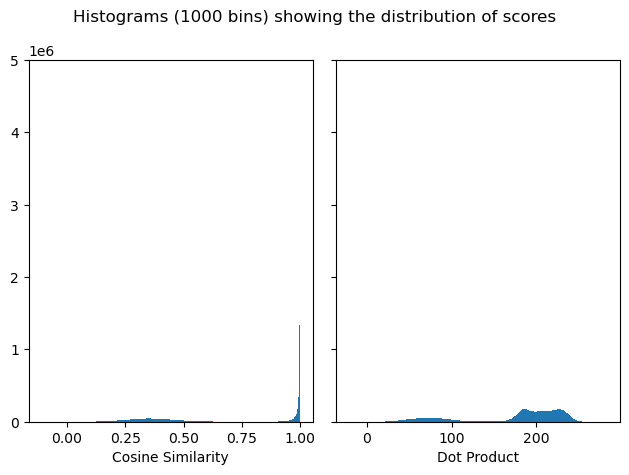

In [6]:
#results_class.histogram_plot(global_results_df = global_results_df) #Change the max of set_ylim in histogram_plot if the plot size is not optimal

In [7]:
cos_lowest_scores_df = results_class.lowest_scores(metrics[0],n=n, plot=plot,results_df = global_results_df)
#dot_lowest_scores_df = results_class.lowest_scores(metrics[1],n=n, plot=plot,results_df = global_results_df)

In [19]:
cos_lowest_scores_df.head()

,Chromosome,Index_in_bed,Begin_Region,End_Region,Begin_6mer,Cosine_Similarity,Dot_Product,1-L1_Loss,1-MSE_Loss
0,chr5,54925,178244652,178265130,178263990,-0.108975,-21.770006,0.480484,0.567299
1,chr6,56509,56085561,56088561,56087655,-0.094808,-18.364891,0.493058,0.585779
2,chr3,44259,15472688,15480668,15476222,-0.078785,-15.581303,0.482353,0.583194
3,chrX,69486,128417676,128420676,128419572,-0.078655,-15.227459,0.494749,0.591900
4,chr17,28955,76300203,76303371,76302747,-0.078509,-15.352283,0.498186,0.588049


### Find the lowest scores across all the regions close to a certain gene

In [64]:
genes = pd.read_csv(f'{patient}/gene_list.txt',sep="\t",header=None)
genes.columns = ["Chromosome","Start","Gene"]

In [69]:
index_list = []
gene_list = []
cos_list = []
bed_list = []
begin_list = []
chr_list = []
end_list = []
sixmer_list = []
shift_list = []
for index_g, gene in genes.iterrows():
    #print(gene["Gene"])
    
    lowest = cos_lowest_scores_df[(cos_lowest_scores_df["Chromosome"] == gene["Chromosome"]) & (abs(cos_lowest_scores_df["Begin_Region"]-gene["Start"])<10000)].head(1)
    if lowest.shape[0]==1:
        index_list.append(lowest.index.item())
        gene_list.append(gene["Gene"])
        cos_list.append(lowest["Cosine_Similarity"].item())
        bed_list.append(lowest["Index_in_bed"].item())
        begin_list.append(lowest["Begin_Region"].item())
        end_list.append(lowest["End_Region"].item())
        sixmer_list.append(lowest["Begin_6mer"].item())
        shift_list.append(lowest["Begin_Region"].item()-gene["Start"])
        chr_list.append(lowest["Chromosome"].item())
    else:
        print(f"{gene["Gene"]} not found.")

C12ORF65 not found.
COX10 not found.
COX11 not found.
LRPPRC not found.
MT-ATP6 not found.
MT-ND1 not found.
MT-ND2 not found.
MT-ND3 not found.
MT-ND4 not found.
MT-ND5 not found.
MT-ND6 not found.
MT-TK not found.
MT-TL1 not found.
MT-TV not found.
MT-TW not found.
NDUFA1 not found.
NDUFA4 not found.
NDUFA10 not found.
NDUFA11 not found.
NDUFA12 not found.
NDUFAF2 not found.
NDUFAF5 not found.
NDUFS1 not found.
NDUFS4 not found.
PDHA1 not found.
PDHB not found.
PDHX not found.
PDSS2 not found.
SDHAF1 not found.
SLC19A3 not found.
SUCLA2 not found.
SUCLG1 not found.
SURF1 not found.
TACO1 not found.
UQCRQ not found.


In [70]:
df = pd.DataFrame({"Lowest_Score_Index":index_list,"Gene_Name":gene_list,"Chromosome":chr_list,"Index_in_bed":bed_list,"Begin_Region":begin_list,"End_Region":end_list,"Begin_6mer":sixmer_list,"Dif_6mer_Gene_Begin":shift_list,"Cosine_Similarity":cos_list}).sort_values(by="Lowest_Score_Index")

In [76]:
display(df)
"""
No fitting mutations found (list from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4235479/ )
    -mutation 8993T>G is present in chrM (MT-ATP6), which is the most common cause of Leigh Syndrome
    -mitochondrial chromosome contains a single N and can therefore usually not be analyzed

    When trying to replace the N with any other base, the lowest cosine similarity generated is 0.076 (approx. the 12000. lowest score)
    Conclusion: Possible that the NT only reacts to significant indels, but not necessarily to SNPs; also possible that it doesnt react to chrM

    Further ideas: Instead of WES/WGS, try looking up known significant mutations (e.g. on ClinVar) and calculate the Cosine Similarity for regions around them
"""

,Lowest_Score_Index,Gene_Name,Chromosome,Index_in_bed,Begin_Region,End_Region,Begin_6mer,Dif_6mer_Gene_Begin,Cosine_Similarity
12,661,PET100,chr19,31413,7637219,7649195,7648985,7426,0.013739
2,2153,FOXRED1,chr11,13444,126259655,126279317,126272195,-9499,0.037486
5,4042,NDUFA9,chr12,13768,4653471,4664547,4663095,4357,0.050381
14,5539,SDHA,chr5,51745,214704,238314,234582,-3616,0.057110
8,12558,NDUFS3,chr11,11141,47573704,47582674,47577556,-5370,0.076091
7,12754,NDUFS2,chr1,4270,161206865,161228951,161224877,4498,0.076479
6,15043,NDUFAF6,chr8,64461,95015431,95018701,95018263,-9558,0.080503
13,15745,SCO2,chr22,43814,50519679,50530335,50522883,-3889,0.081533
4,16100,NDUFA2,chr5,53989,140651786,140654786,140653958,6501,0.082098
10,16885,NDUFS8,chr11,11918,68026035,68037513,68036541,-4646,0.083322


'\nNo fitting mutations found (list from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4235479/ )\n    -mutation 8993T>G is present in chrM (MT-ATP6), which is the most common cause of Leigh Syndrome\n    -mitochondrial chromosome contains a single N and can therefore usually not be analyzed\n\n    When trying to replace the N with any other base, the lowest cosine similarity generated is 0.076 (approx. the 12000. lowest score)\n    Conclusion: Possible that the NT only reacts to significant indels, but not necessarily to SNPs; also possible that it doesnt react to chrM\n'